In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

## 2.1 Introduction

This chapter introduces more PyMC syntax and design patterns, and ways to think about how to model a system from a Bayesian perspective. It also contains tips and data visualization techniques for assesing goodness of fit for your Bayesian model.

#### 2.1.1 Parent and Child Relationships

To assist with describing Bayesisan relationships and to be consistent with PyMC's documentation, we introduce _parent_ and _child_ variables.

* **Parent variables** are variables that influence another variable.
* **Child variables** are variables that are affected by other variables - that is, are the subject of parent variables.

A variable can be both a parent and child. For example, consider the following PyMC code:

In [2]:
import pymc as pm

lambda_ = pm.Exponential("poisson_param", 1)
# used in the call to the next variable ...
data_generator = pm.Poisson("data_generator", lambda_)

data_plus_one = data_generator + 1

```lambda_``` controls the parameter of ```data_generator```, hence influences its values. The former is a parent of the latter. By symmetry, ```data_generator``` is a child of ```lambda_```.

Likewise, ```data_generator``` is a parent to the variable ```data_plus_one``` (hence making ```data_generator``` both a parent and child variable). Although it does not look like one, ```data_plus_one``` should be treated as a PyMC variable as it is a _function_ of another PyMC variable, hence is a child variable to ```data_generator```

This nomentclature is introduced to help us describe relationships in PyMC modeling. You can access a variable's children and parent variables using the ```children``` and ```parents``` attributes attached to variables.



In [3]:
print "Children of 'lambda_': "
print lambda_.children
print "\n Parents of 'data_generator': "
print data_generator.parents
print "\n Children of 'data_generator': "
print data_generator.children

Children of 'lambda_': 
set([<pymc.distributions.Poisson 'data_generator' at 0x000000000C7F2240>])

 Parents of 'data_generator': 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x0000000008B965C0>}

 Children of 'data_generator': 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x0000000008B964A8>])


### 2.1.2 PyMC Variables

All PyMC variables expose a ```value``` property. This property produces the _current_ (possibly random) internal value of the variable. If the variable is a child variable, its value changes given the variable's parents' values.
Using the same variables from before:

In [4]:
print "lambda_.value = ", lambda_.value
print "data_generator.value = ", data_generator.value
print "data_plus_one.value = ", data_plus_one.value

lambda_.value =  0.714540440115
data_generator.value =  0
data_plus_one.value =  1


PyMC is concerned with two types of programming variables: ```Stochastic``` and ```deterministic```.

* **Stochastic variables** are variables that are not deterministic, i.e. even if you knew all the values of the variables' parents (if if even has any parents), it would still be random. Included in this category are instances of classes ```Poisson, DiscreteUniform```, and ```Exponential```.
* **Deterministic variables** are variables that are not random if the variables's parents are known. This might be confusing at first; a quick mental check is _if I knew all of the variale foo's parent variables' values, I could determine exactly what foo's value is._

### Initializing Stochastic Variables

The first argument in initializing a stochastic variable is a string that represents the name of the variable.
After that are additional arguments that are class-specific. Zum Beispeil:

In [5]:
some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)

where 0, 4 are the ```DiscreteUniform```-specific lower and upper bound on the random variable.

In [7]:
# pm.DiscreteUniform??

The name argument is used to retreive the posterior distribution later in the analysis, so it is best to use a descriptive name. Typically, I use the Python variable's name.

For multivariable problems, rather than creating a Python array of stochastic variables, setting the ```size``` keyword in the call to a ```Stochastic``` variable creates an array of (independent) stochastic variables. The array behaves like a NumPy array when used like one, and references to its ```value``` attribute return NumPy arrays.

The ```size``` argument also solves the annoying case wher eyou may have many variables
$\beta_i, i = 1, ... N$ you wish to model.
Instead of creating arbitrary names and variabels for each one, like:

```
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)
...
```

We can instead wrap them in a single variable:
```
betas = pm.Uniform("betas", 0, 1, size=N)
```

In [9]:
## pm.Uniform??

### Calling ```random()```

We can also call on a stochastic variable's ```random()``` method, which (given the parent values) will generate a new, random value.
We demonstrate this using the texting example from Chapter 1

In [11]:
lambda_1 = pm.Exponential("lambda_1", 1) # prior on first behavior
lambda_2 = pm.Exponential("lambda_2", 1) # prior on second behavior
tau = pm.DiscreteUniform("tau", lower=0, upper = 10) # prior on behavior change

In [14]:
print "Initialized values ... "
print "lambda_1.value: %.3f " % lambda_1.value
print "lambda_2.value: %.3f " % lambda_2.value
print "tau.value: %.3f " % tau.value

lambda_1.random(), lambda_2.random(), tau.random()

print "After calling random() on the variables ... "
print "lambda_1.value: %.3f " % lambda_1.value
print "lambda_2.value: %.3f " % lambda_2.value
print "tau.value: %.3f " % tau.value

Initialized values ... 
lambda_1.value: 0.465 
lambda_2.value: 0.998 
tau.value: 6.000 
After calling random() on the variables ... 
lambda_1.value: 0.042 
lambda_2.value: 0.440 
tau.value: 10.000 


The call to ```random``` stores a new value into the variable's ```value``` attribute.

### Determistic Variables

Since most variables you will be modeling are stochastic, we distinguish variables with a 
```pymc.deterministic``` wrapper. (If you are unfamiliar with Python wrappers - also called _decorators_ - that's no problem. Just prepend the ```pymc.deterministic``` decorator before the variable declaration and you're good to go.) The declaration of a deterministic variable uses a Python function:

```
@pm.deterministic
def some_deterministic_var(v1=v1,):
    # jelly goes here.
```


For all purposes, we treat the object ```some deterministic var``` as a variable and not a Python function.

Prepending with the wrapper is the easiest way, but not the only way, to create deterministic variables. Elementary operations, like addition, exponentials, and so forth implicitly create deterministic variables. Zum Beispeil, the following returns a deterministic variable:

```
type(lambda_1 + lambda_2)
```

In [15]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [16]:
import numpy as np
n_data_points = 5

@pm.deterministic
def lambda_(tau = tau, lambda_1=lambda_1,lambda_2 =lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

Clearly, if $\tau, \lambda_1$ and $\lambda_2$ are known, then $\lambda$ is known completely; hence, it is a 
deterministic variable.

Inside the deterministic decorator, the ```Stochastic``` variables passed in behave like scalars or NumPy arrays (if multivariable), and _not_ like ```Stochastic``` variables. For example:

```
@pm.deterministic
def some_deterministic(stoch=some_stochastic_var):
    return stoch.value**2
```

will return an ```AttributeError``` detailing that ```stoch``` does not have a ```value``` attribute.
It simply needs to be ```stoch**2```.
During the learning phase, it's the variable's ```value``` that is repeatedly passed in, not the actual stochastic variable.

Notice that in the creation of the deterministic function that we use keyword arguments for each variable used in the function. This is a necessary step, and all variables _must_ be specified with keyword arguments.

### Including Observations in the Model

At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like, "What does my prior distribution of $\lambda_1$ look like?", as demonstrated below:

(0, 10)

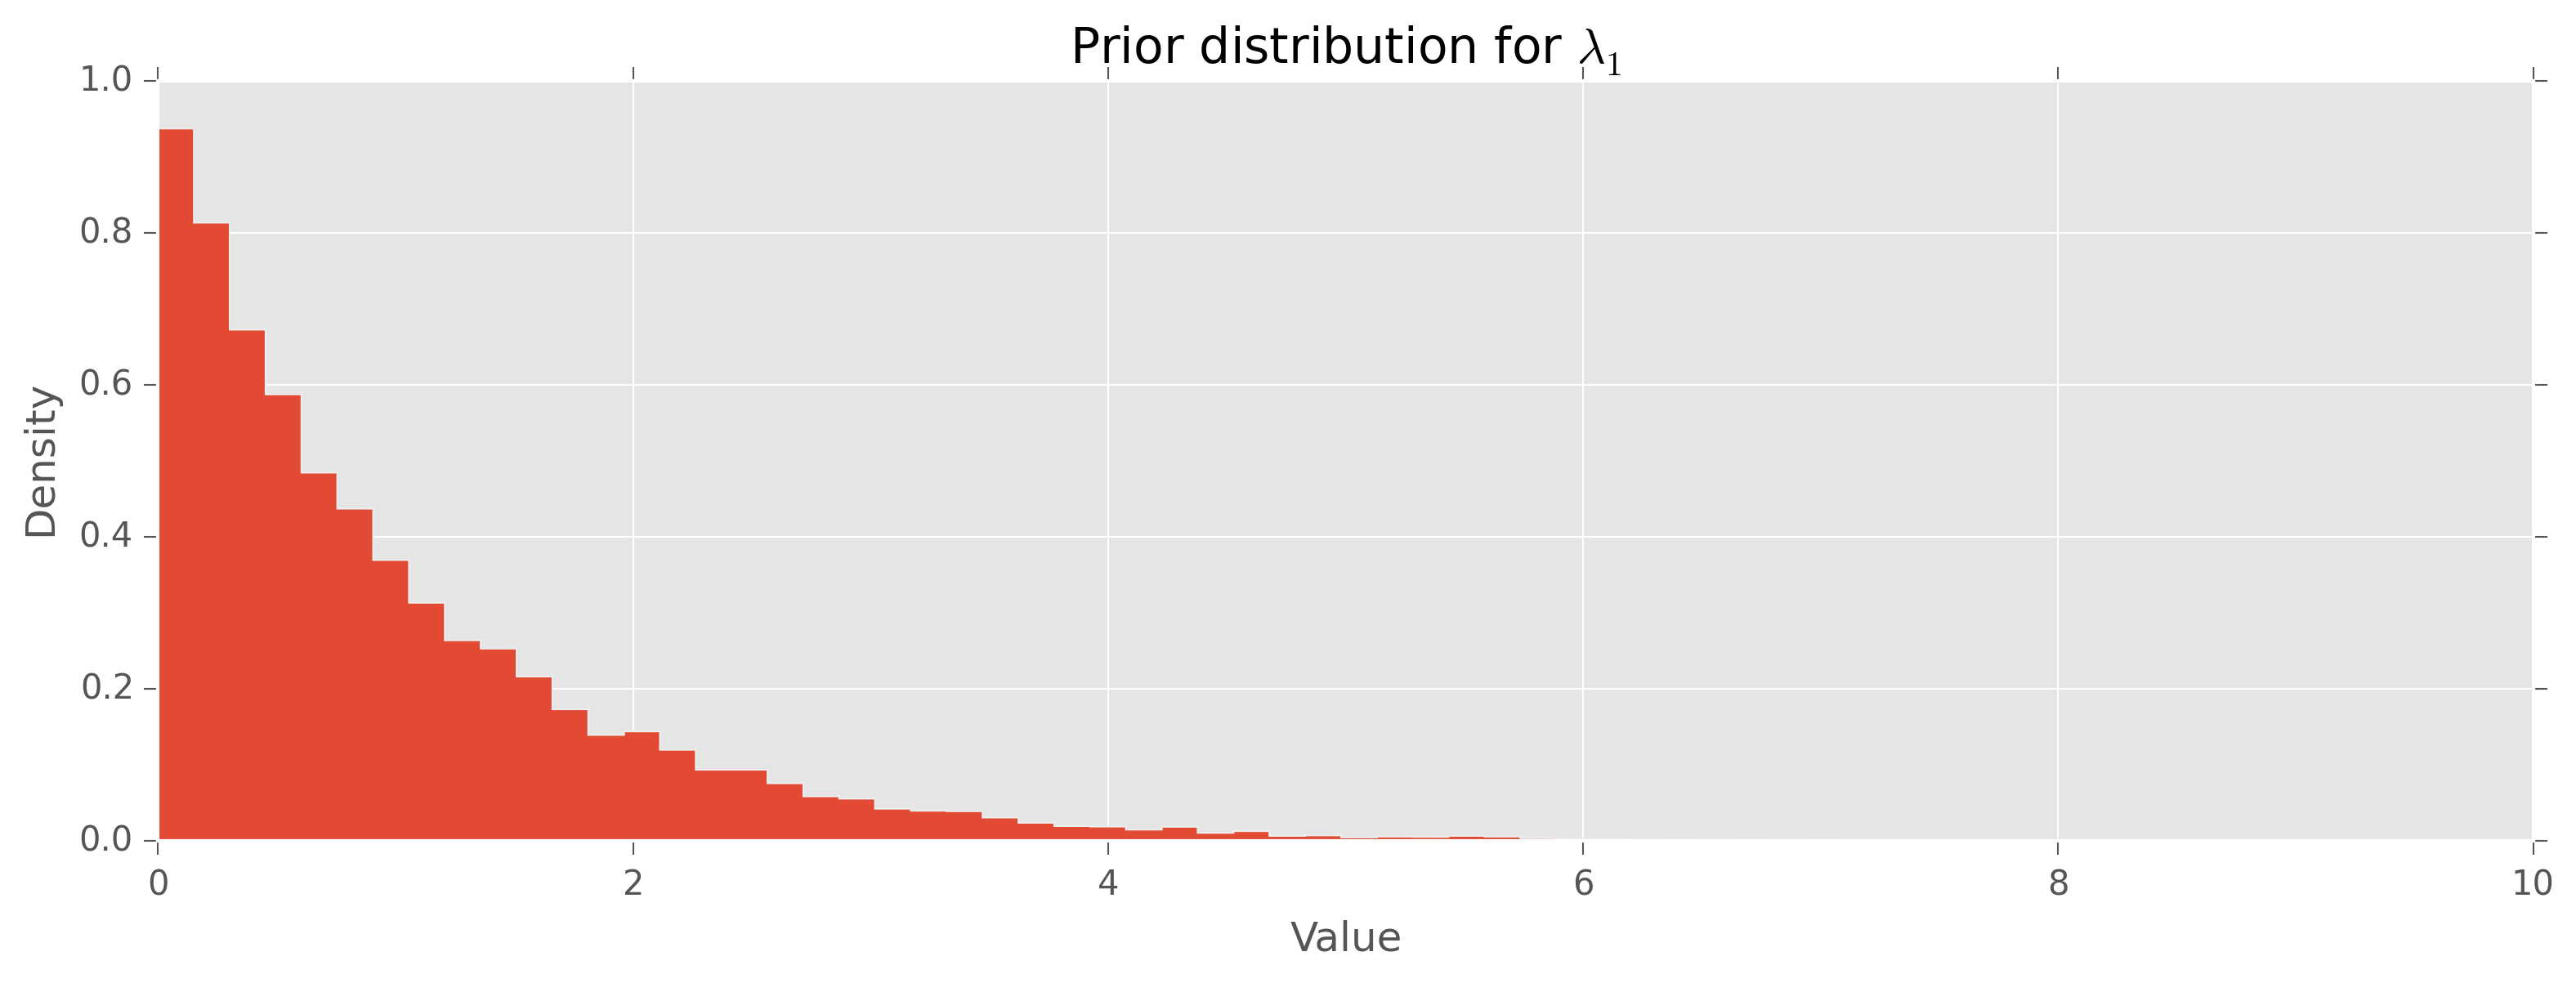

In [22]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plot
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
samples = [lambda_1.random() for i in range(20000)]

plt.hist(samples, bins=70, normed=True,histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0,10)

To frame this in the notation of chapter 1, though this is a slight abuse of notation, we have specified P(A). Our next goal is to include data/evidence/observations X into our model. We model this next.

PyMC stochastic variables have an additional keyword argument ```observed``` which accepts a boolean (```False``` by default).
The keyword ```observed``` has a very simple role: fix the variable's current value. That is, it makes ```value``` immutable. We hvea to specifiy an initial ```value``` in the variable's creation, equal to the observations we wish to include, typically an array (and it should be a NumPy array for speed.) for example:

In [20]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print "value: ", fixed_variable.value
print "Calling .random()"
fixed_variable.random()
print "value: ", fixed_variable.value

value:  [10  5]
Calling .random()
value:  [10  5]


This is how we include data into our models: initializing a stochastic variable to have a _fixed value_.
To complete our text-message example, we fix the PyMC variable ```observations`` to the observed dataset.

In [21]:
# We're using some fake data here.
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print obs.value

[10 25 15 20 35]


### 2.1.4 Finally...

We wrap all the created variables into a ```pm.Model``` class. With this ```Model``` class, we can analyze the variables as a single unit. This is an optional step, as the fitting algorithms can be sent an array of the variables rather than a ```Model``` class. I may or may not perform this step in all future examples

In [23]:
model = pm. Model([obs, lambda_, lambda_1, lambda_2, tau])

### 2.2 Modeling Approaches

A good starting thought to Bayesian modeling is to think about _how your data might have been generated_. Position yourself as an omniscent controller, and try to imagine how _you_ would recreate the dataset.

In Chapter 1, we investigated text-message data.
We began by asking how our observations may have been generated.

1. We started by thinking, "What is the best random variable to descirbe this count data?" A Poisson random variable is a good candidate because it can represent count data well. So we model the number of text messages received as sampled from a Poisson distribution.
2. Next, we think, "OK, assuming text messages are Poisson-distributed, what do I need for the Poisson distribution?" Well, the 
Poisson distribution has a parameter $\lambda$.
3. Do we know $\lambda$? No. In fact, we have a suspiciion that there are _two_ $\lambda$ values, one for earlier behavior and one for later behavior. We don't know when the behavior switches, though, but call the switchpoint $\tau$.
4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well, the exponential distribution has a parameter too - call it $\alpha$.
5. Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance; whereas we have a prior belief about $\lambda$ ("If probably changes over time," "it'slikely between 10 and 30," etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop modeling here. What is a good value for $\alpha$, then? We think that the $\lambda$s are between 10 and 30, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similarly, a too-high $\alpha$ misses our prior belief as well. A good idea for $\alpha$ ro reflect our beliefs about $\lambda$ is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean.
6. We have no expert opinion of when $\tau$ might have occured. So we suppose $\tau$ is from a discrete uniform distibution over the entire time span.



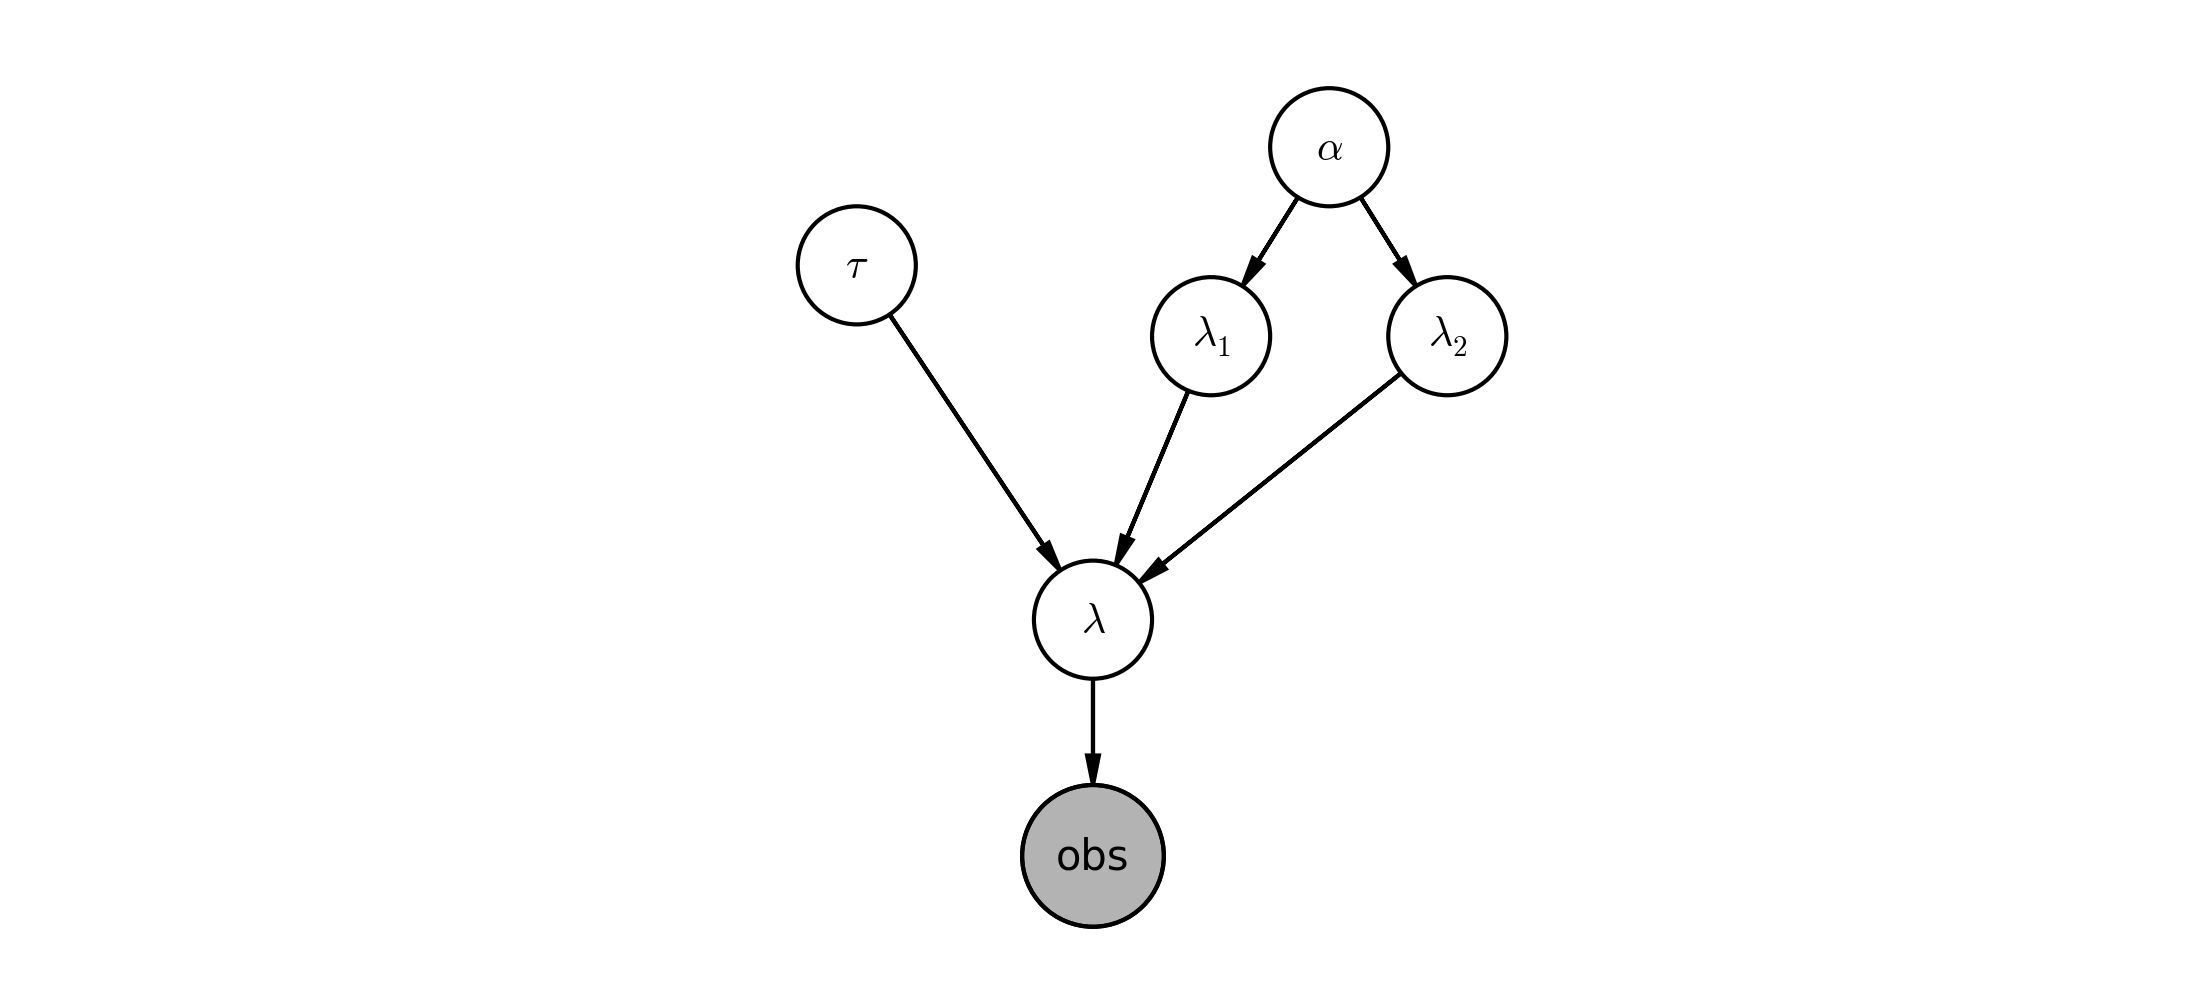

In [24]:
#daft drawing for SMS example
import matplotlib.pyplot as plt



try:
    import daft
except ImportError:
    print "python library Daft required."
    

pgm = daft.PGM([9, 4], origin=[.5,.5])
pgm.add_node(daft.Node("tau", r"$\tau$", 4.0, 3.5))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 6, 4.0))
pgm.add_node(daft.Node("lambda1", r"$\lambda_1$", 5.5, 3.2,))
pgm.add_node(daft.Node("lambda2", r"$\lambda_2$", 6.5, 3.2))
pgm.add_node(daft.Node("lambda", r"$\lambda$", 5.0, 2.0))
pgm.add_node(daft.Node("obs", "obs", 5.0, 1.0, 1.2, observed=True))



pgm.add_edge("tau", "lambda")
pgm.add_edge("alpha", "lambda1")
pgm.add_edge("alpha", "lambda2")
pgm.add_edge("lambda1", "lambda")
pgm.add_edge("lambda2", "lambda")

pgm.add_edge("lambda", "obs")
pgm.render()
plt.figure( figsize=(12,5) )
plt.show()

PyMC, and other probabilistic programming languages, have been designed to tell these data-generation _stories_. More generally, Cronin writes:

```
Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories—thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.
```

## 2.2.1 Same Story, Different Ending

Interestingly, we can create _new datasets_ by retelling the story. For example, if we reverse the six steps just discussed, we can simulate a possible realization of the dataset.

In the following, we use PyMC's internal functoins for generating random variables (but that are not ```Stochastic``` variables.) The function ```rdiscrete_uniform``` will create random output from a discrete uniform distribution (similar to ```numpy.random.randint```).

1. Specify when the user's behavior switches by sampling from DiscreteUniform(0, 80)



In [25]:
tau = pm.rdiscrete_uniform(0, 80)
print tau

44


2. Draw $\lambda_1$ and $\lambda_2$ from an Exp($\alpha$) distribution

In [26]:
alpha = 1./20
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2

7.40971215267 0.580978306651


3. For days before $\tau$, $\lambda = \lambda_1$; for days after $\tau, \lambda = \lambda_2$:

In [35]:
lambda_ = np.r_[lambda_1*np.ones(tau), lambda_2*np.ones(80-tau) ] 
print lambda_

#lambda_ = np.r_[17*np.ones(45), 23*np.ones(80-45) ] 
#print lambda_



[ 7.40971215  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215
  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215
  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215
  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215
  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215
  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215
  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215  7.40971215
  7.40971215  7.40971215  0.58097831  0.58097831  0.58097831  0.58097831
  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831
  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831
  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831
  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831
  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831  0.58097831
  0.58097831  0.58097831]


4. Sample from Poi($\lambda_1$), and sample from Poi($\lambda_2$) for days after $\tau$. For example:

In [36]:
data = pm.rpoisson(lambda_)
print data

[10  6  5  6 13  6  7  6  9  5 15 10  5  8  5 10 11 10  7  7  6  5  6  4  9
  6 11  9  8  4  4  6  7  8  7  7  7 11 12  7  4 11 10 10  0  0  1  0  1  0
  0  0  1  1  1  1  2  0  0  2  3  0  0  1  1  1  0  0  0  0  2  0  0  0  0
  2  0  1  0  0]


5. Plot the artificial dataset:

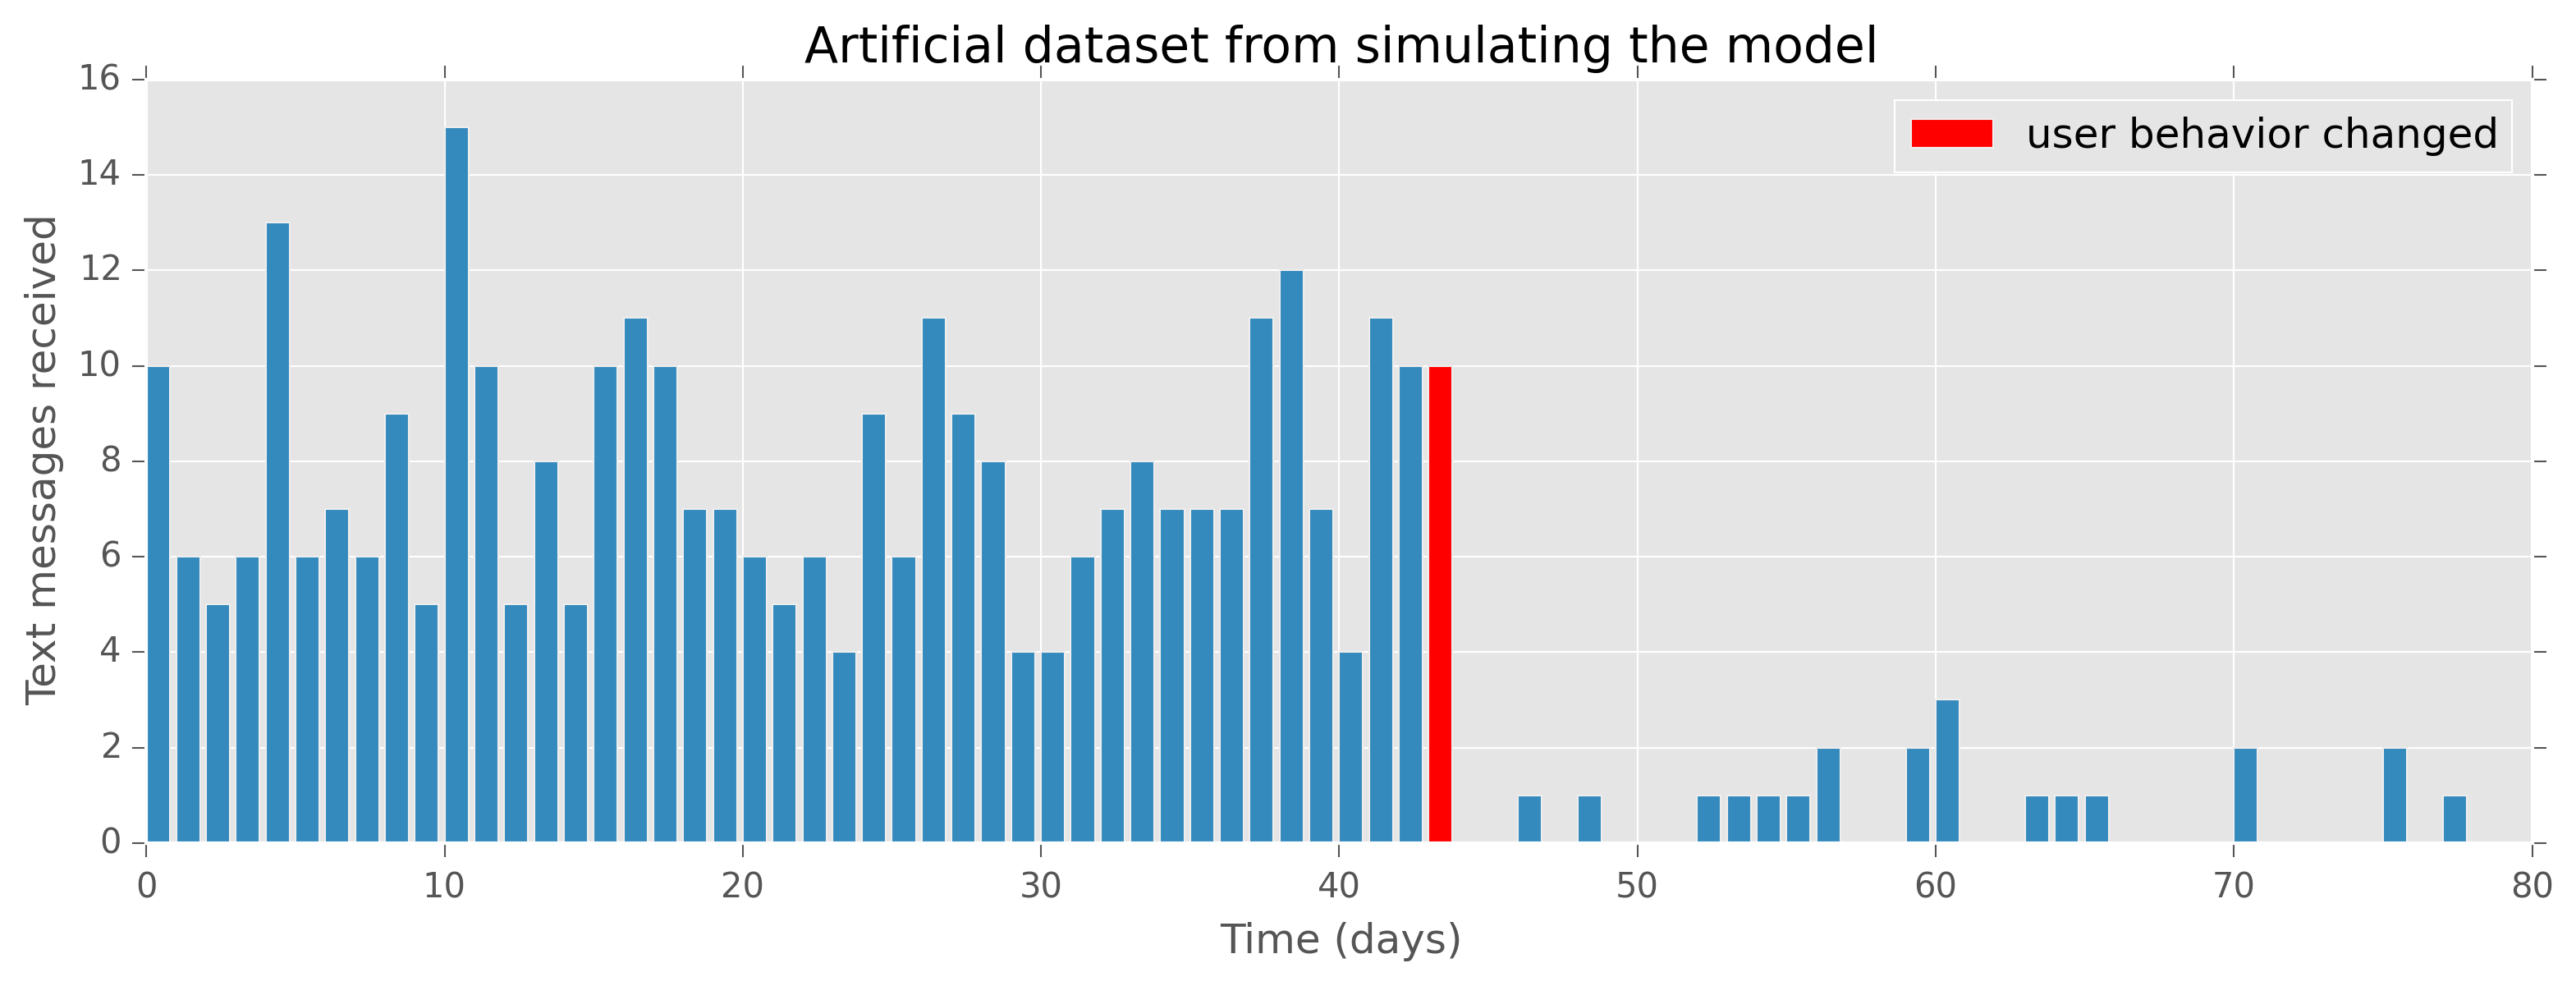

In [37]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau-1], color="r",label="user behavior changed")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Artificial dataset from simulating the model")
plt.xlim(0, 80)
plt.legend()

In [38]:
tau

44

It is okay that the fictional dataset does not like our observed dataset; indeed, the probability is incredibly small that it wold. PyMC's engine is designed to find good parameters - $\lambda_i, \tau$ - that maximize this probability.

The ability to generate an artificial dataset is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference. For example, we'll produce a few more datasets.

In [39]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1./20
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80-tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behavior changed")
    
    

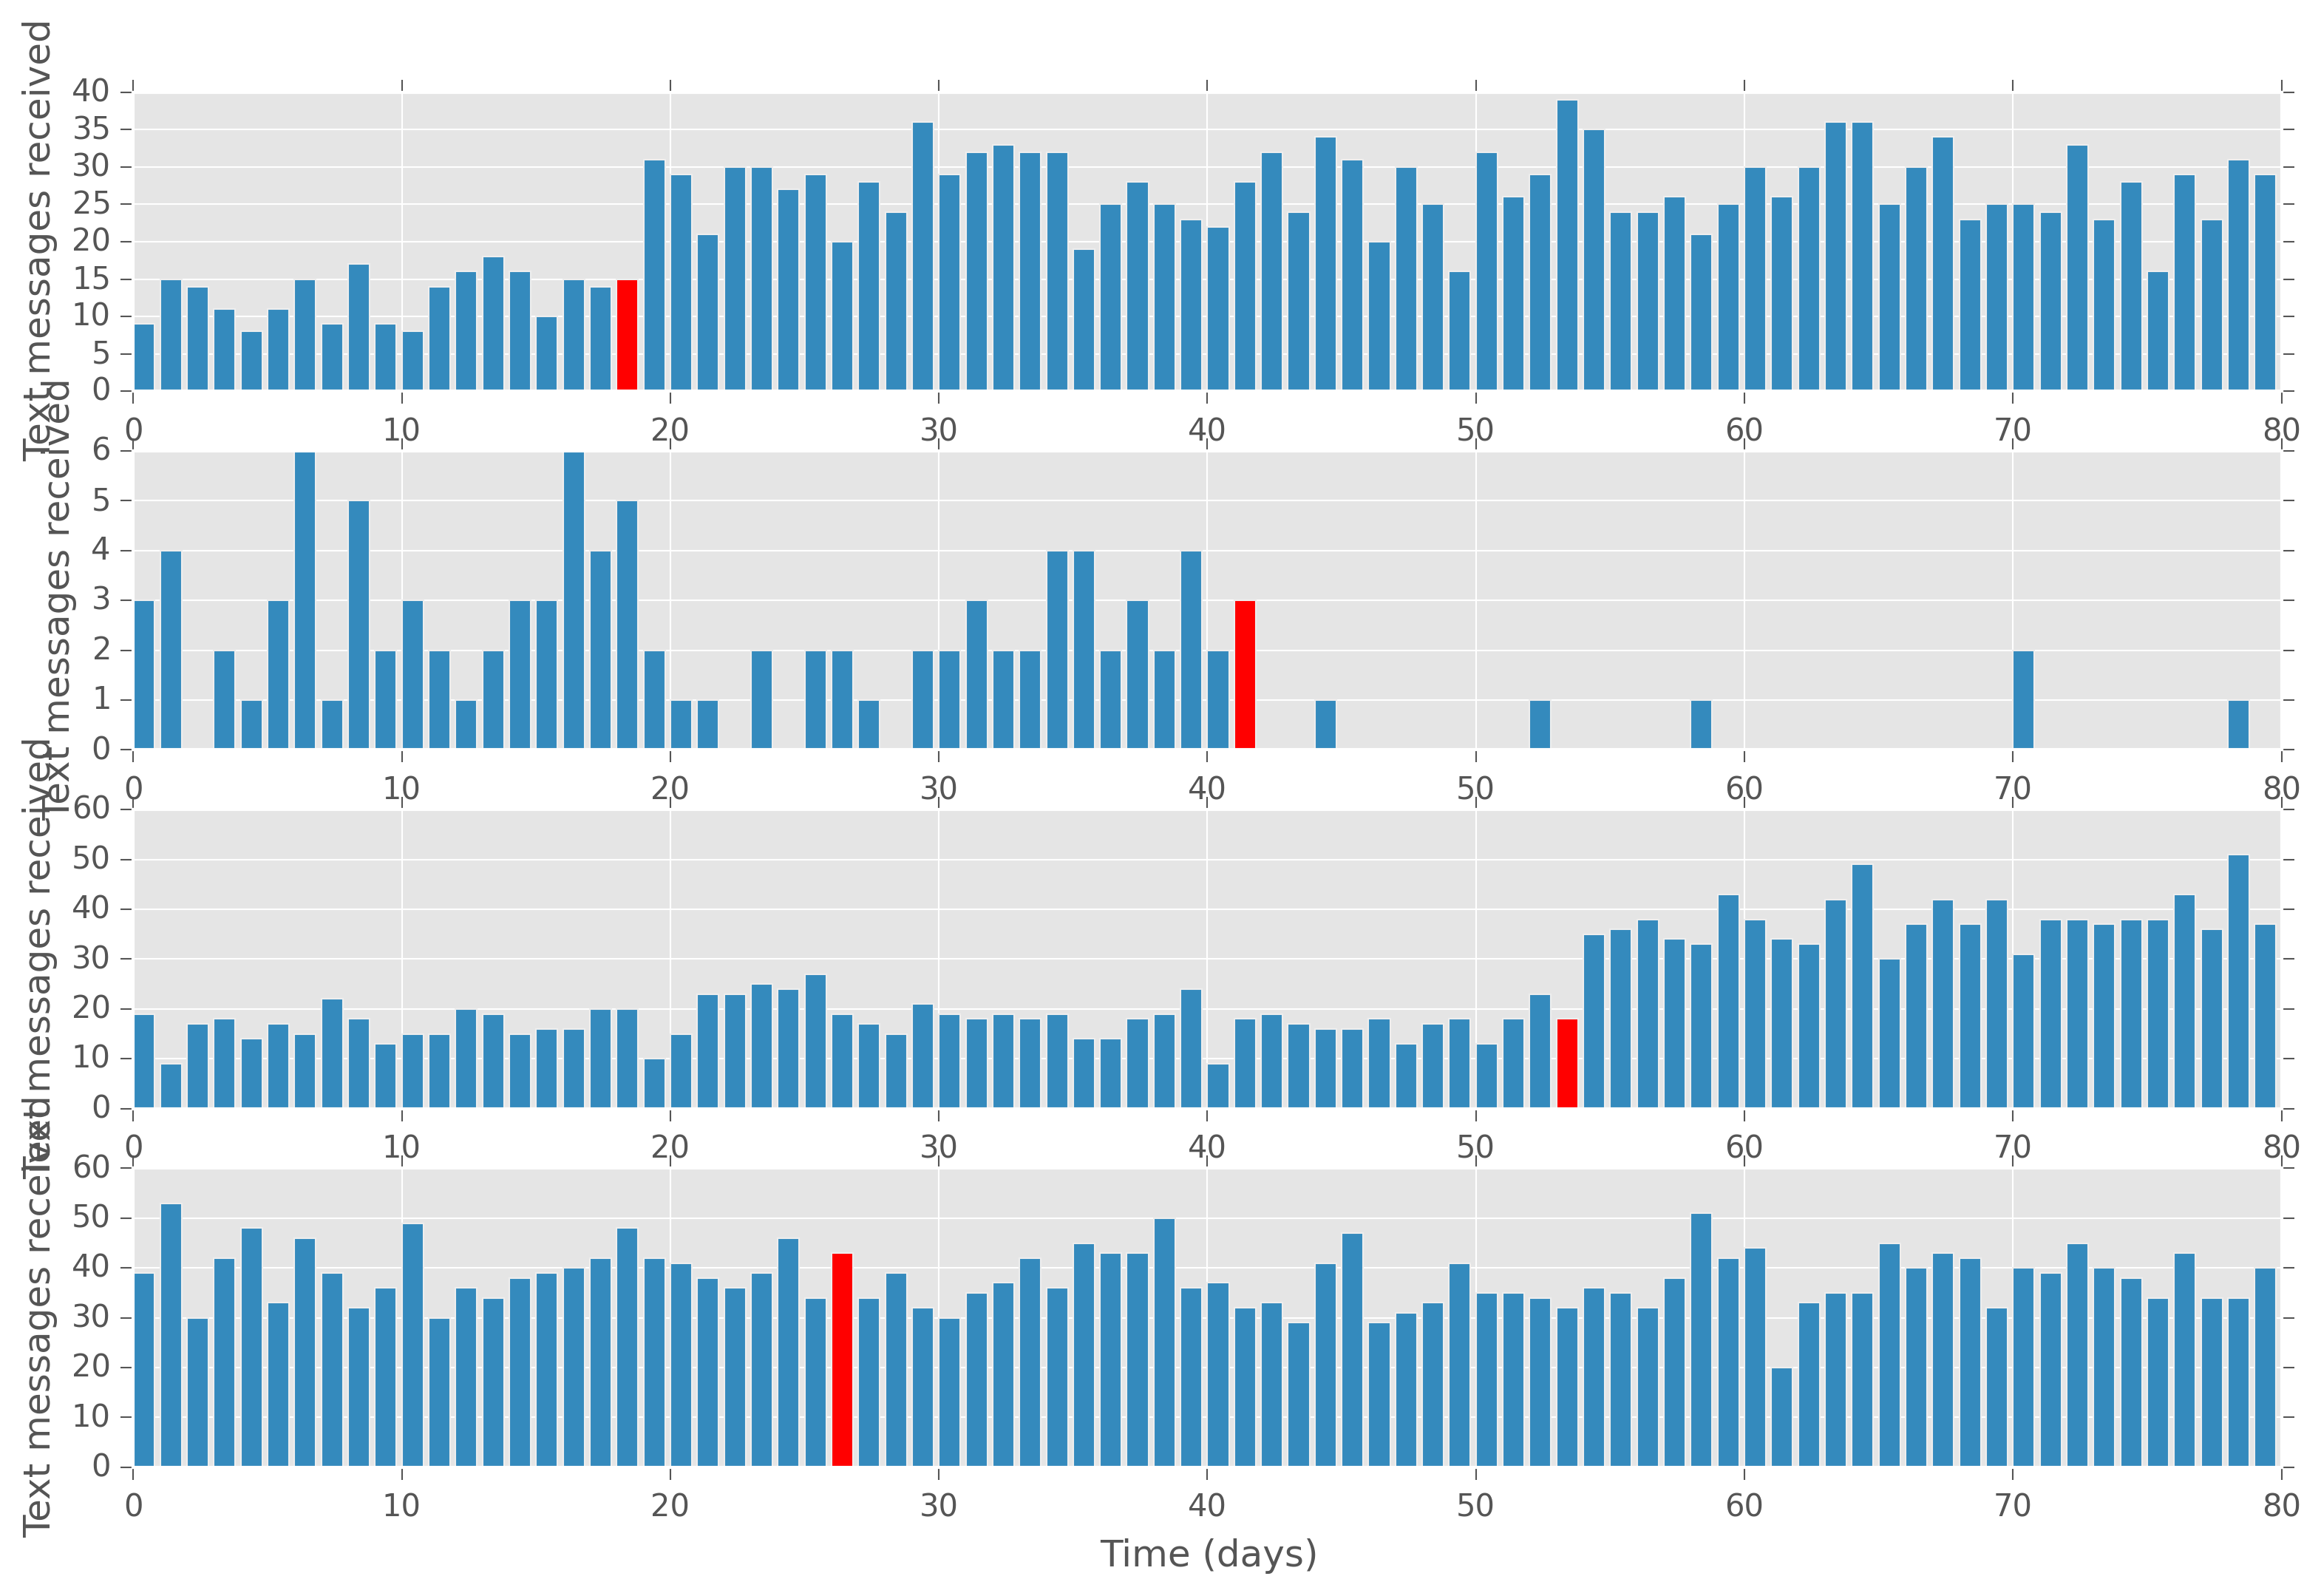

In [41]:
figsize(12.5, 8)
plt.title("More examples of artificial datasets \n from simulating our model")
for i in range(4):
    plt.subplot(4,1, i+1)
    plt.xlabel("Time (days)")
    plt.ylabel("Text messages received")
    plot_artificial_sms_dataset()

Later we will see how we use this to make predictions and test the appropriateness of our models.

## 2.2.2 Example: Bayesian A/B Testing

A/B testing is a stastistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A versus drug B. The company will test drug A on some percentage of a patient group, and drug B on the rest (this split is often 50%/ 50%, but we will relax this assumption). After performing enough trials, the in-house statisticians measure the effectiveness to determine which drug yielded better results.

Similarly, front-end Web developers are interested in which design of their Web site yields more _conversions_, where a conversion could be a visitor signing up, purchasing something, or taking some other action. They will route some fraction of visitors to site A, and the other fraction to site B (Which has an alternate design), and record if teh visit yielded a conversion or not. The assignments and conversions are recorded and analyzsed afterwaqrd.

The key value of A/B tests is that there is only a single difference between groups. Thus, any significant change in the metrics (like drug effectiveness or conversions) can be directly attributed to this difference.

Often, the post-experiment analysis is done using something called a "hypothesis test" like a _difference of means test_ or _difference of proportions test_. This involves often misunderstood quantities likea "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily _learned_ this technique). And if you were like me, you have have felt uncomfortable with their derivation. If so, good. The Bayesian approach to this problem is much more natural.

## 2.2.3 A Simple Case

As this is a _hacker_ book, we'll continue with the web-development example. For the moment, we will focus on the analysis of site A first. Assume that there is some probability, $p_A$, that users who are shown site A eventually convert. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people converted. One might hastily conclude that $p_A = \frac{n}{N}$.
Unfortunately, this _observed frequency_ $\frac{n}{N}$ does not necessarily equal $p_A$; there is a difference between the 
_observed frequency_ and the _true frequency_ of an event. The true frequency can be interpreted as the probability of an event occurring, and this does not necessarily equal the observed frequency. For example, the true frequency of rolling a 1 on a six-sided die is $\frac{1}{6}$, but if we roll the dice six times we may not see a 1 show up at all (The observed frequency)! We must commonly determine the true frequency of events like:

* The fraction of users who make purchaes
* The proportion of some characteristic in a population
* The percentage of Internet userse with cats
* Or the probability that it will rain tomorrow

Unfortunately, noise and complexities hide the true frequency from us and we must _infer_ it from observed data. We use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data. With respect ot our conversion example, we are interested in using what we know, $N$ (the total visitors) and $n$ (the number of conversions) to estimate what $p_A$, the true frequency of conversion, might be.

To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. _A priori_, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1].

In [113]:
import pymc as pm

# The parameters are the bounds of the Uniform
p = pm.Uniform('p', lower=0, upper=1)

For this example, suppose $p_A = 0.05$, and $N = 1,500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a **Bernoulli distribution**. A Bernoulli distribution is a binary random variable (0 or 1 only), and as our observations are binary (not convert or convert), it is appropriate here. More formally, if $X \sim Ber(p)$, then $X$ is 1 with probability $p$ and 0 with probabilty $1-p$. 
Of course, in practice we do not know $p_A$, but we will use it here to simulate artifical data.

In [114]:
# set constants
p_true = 0.05 # remember, this is unknown in real life
N = 1500000
# sample N Bernoulli random variables from Ber(0.05)
# Eacah random variable has a 0.05 chance of being 1
# This is the data-generation step

occurrences = pm.rbernoulli(p_true, N)

print occurrences # Remeber: Python treats True == 1, and False == 0
print occurrences.sum()

[False False  True ..., False False False]
74831


In [115]:
74831/1500000.

0.04988733333333333

In [116]:
# Occurences.mean() is equal to n/N

print "What is the observed frequency in Group A? %.4f" % occurrences.mean()
print "Does the observed frequency equal the true frequency? %s " % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0499
Does the observed frequency equal the true frequency? False 


We combine the observations into the PyMC ```observed``` variable, and run our inference algorithm:

In [117]:
# Include the observations, which are Bernoulli

obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# to be explained in Chapter 3

mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 259.2 sec

We plot the posterior distribution of the unknown $p_A$

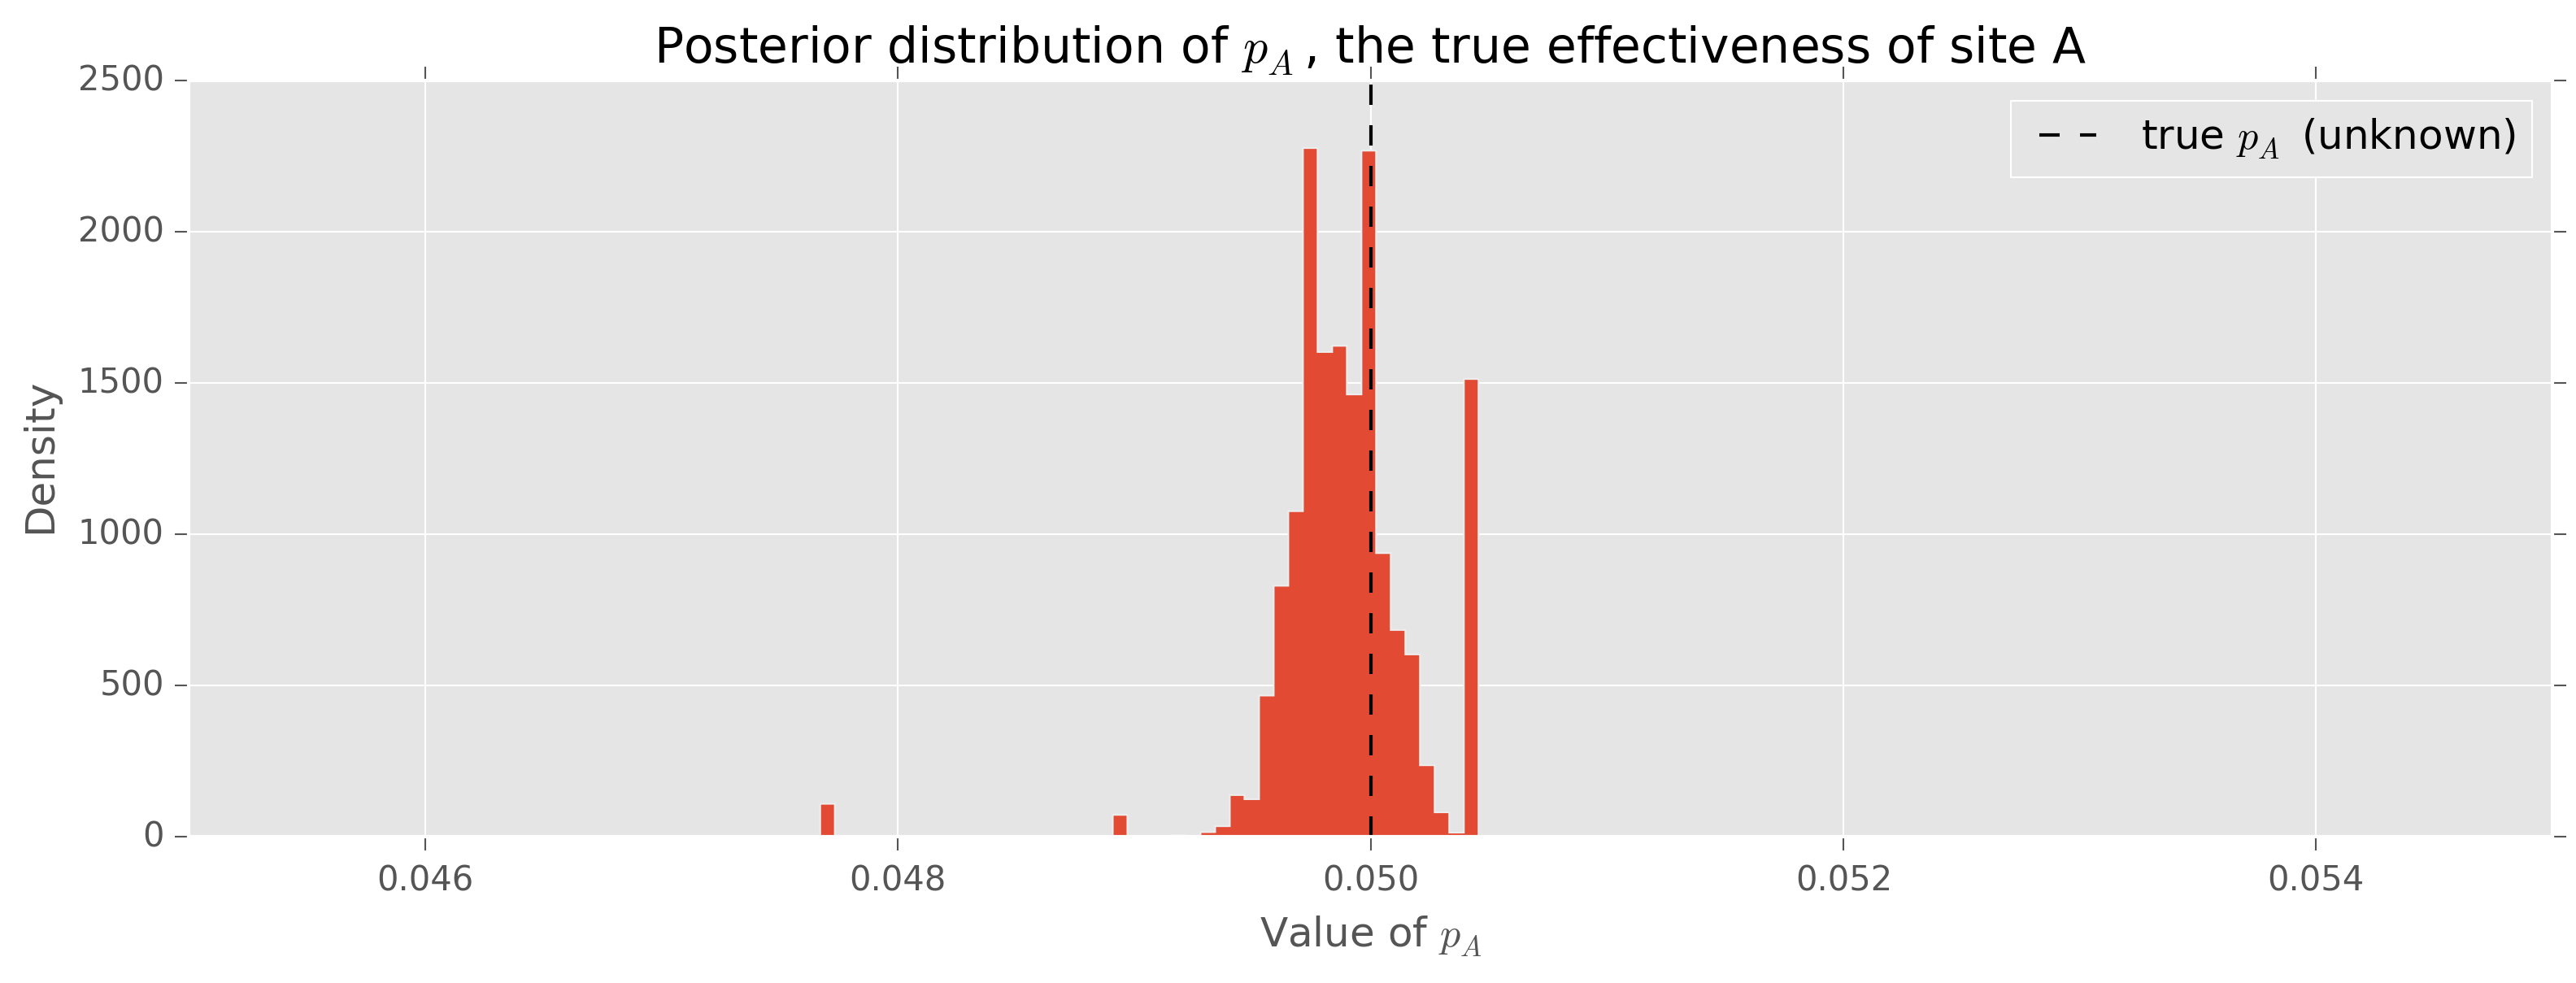

In [120]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 2500, linestyle="--",label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=45, histtype="stepfilled", normed=True)
plt.xlabel("Value of $p_A$")
plt.ylabel("Density")
plt.xlim(0.045,0.055)
plt.legend()

Our posterior distribution puts weight near what our data suggests is the true value of $p_A$: The higher the distrubution, the more likely it is there. Try changing the number of observations, $N$, and observe how the posterior distribution changes.

## 2.2.4 A and B Together

A similar analysis can be done for site B's response data to determine a posterior for $p_B$. What we are really interested in is the _difference_ between $p_A$ and $p_B$. Let's infer $p_A, p_B$ _and_ delta = $p_A - p_B$, all at once. We can do this using PyMC's deterministic variables. We'll assume for this exercise that $p_B = 0.04$ (though we don't know this), so delta = 0.01, $N_B = 750$ (only half of $N_A$) and we will simulate site B's data like we did for site A's data.

In [135]:
import pymc as pm
figsize(12,4)

# these two quantities are unknown to us
true_p_A = 0.05
true_p_B = 0.04

# Notice the unequal sample sizes - no problem in Bayesian analysis

N_A = 1500
N_B = 750

# Generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Obs from Site A: ", observations_A[:30].astype(int), "..."
print "Obs form site B: ", observations_B[:30].astype(int), "..."

Obs from Site A:  [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] ...
Obs form site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [136]:
occurrences[:30]

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [137]:
print observations_A.mean()
print observations_B.mean()

0.0493333333333
0.0373333333333


In [138]:
# Set up the PyMC model. Again assume Uniform priors for p_A and p_B
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# Define the deterministic delta function. This is our uknown of interest
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations; in this case, we have two observation datasets.

obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# to be explained in chapter 3
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.5 sec

We plot the posterior distributions for the three unknowns

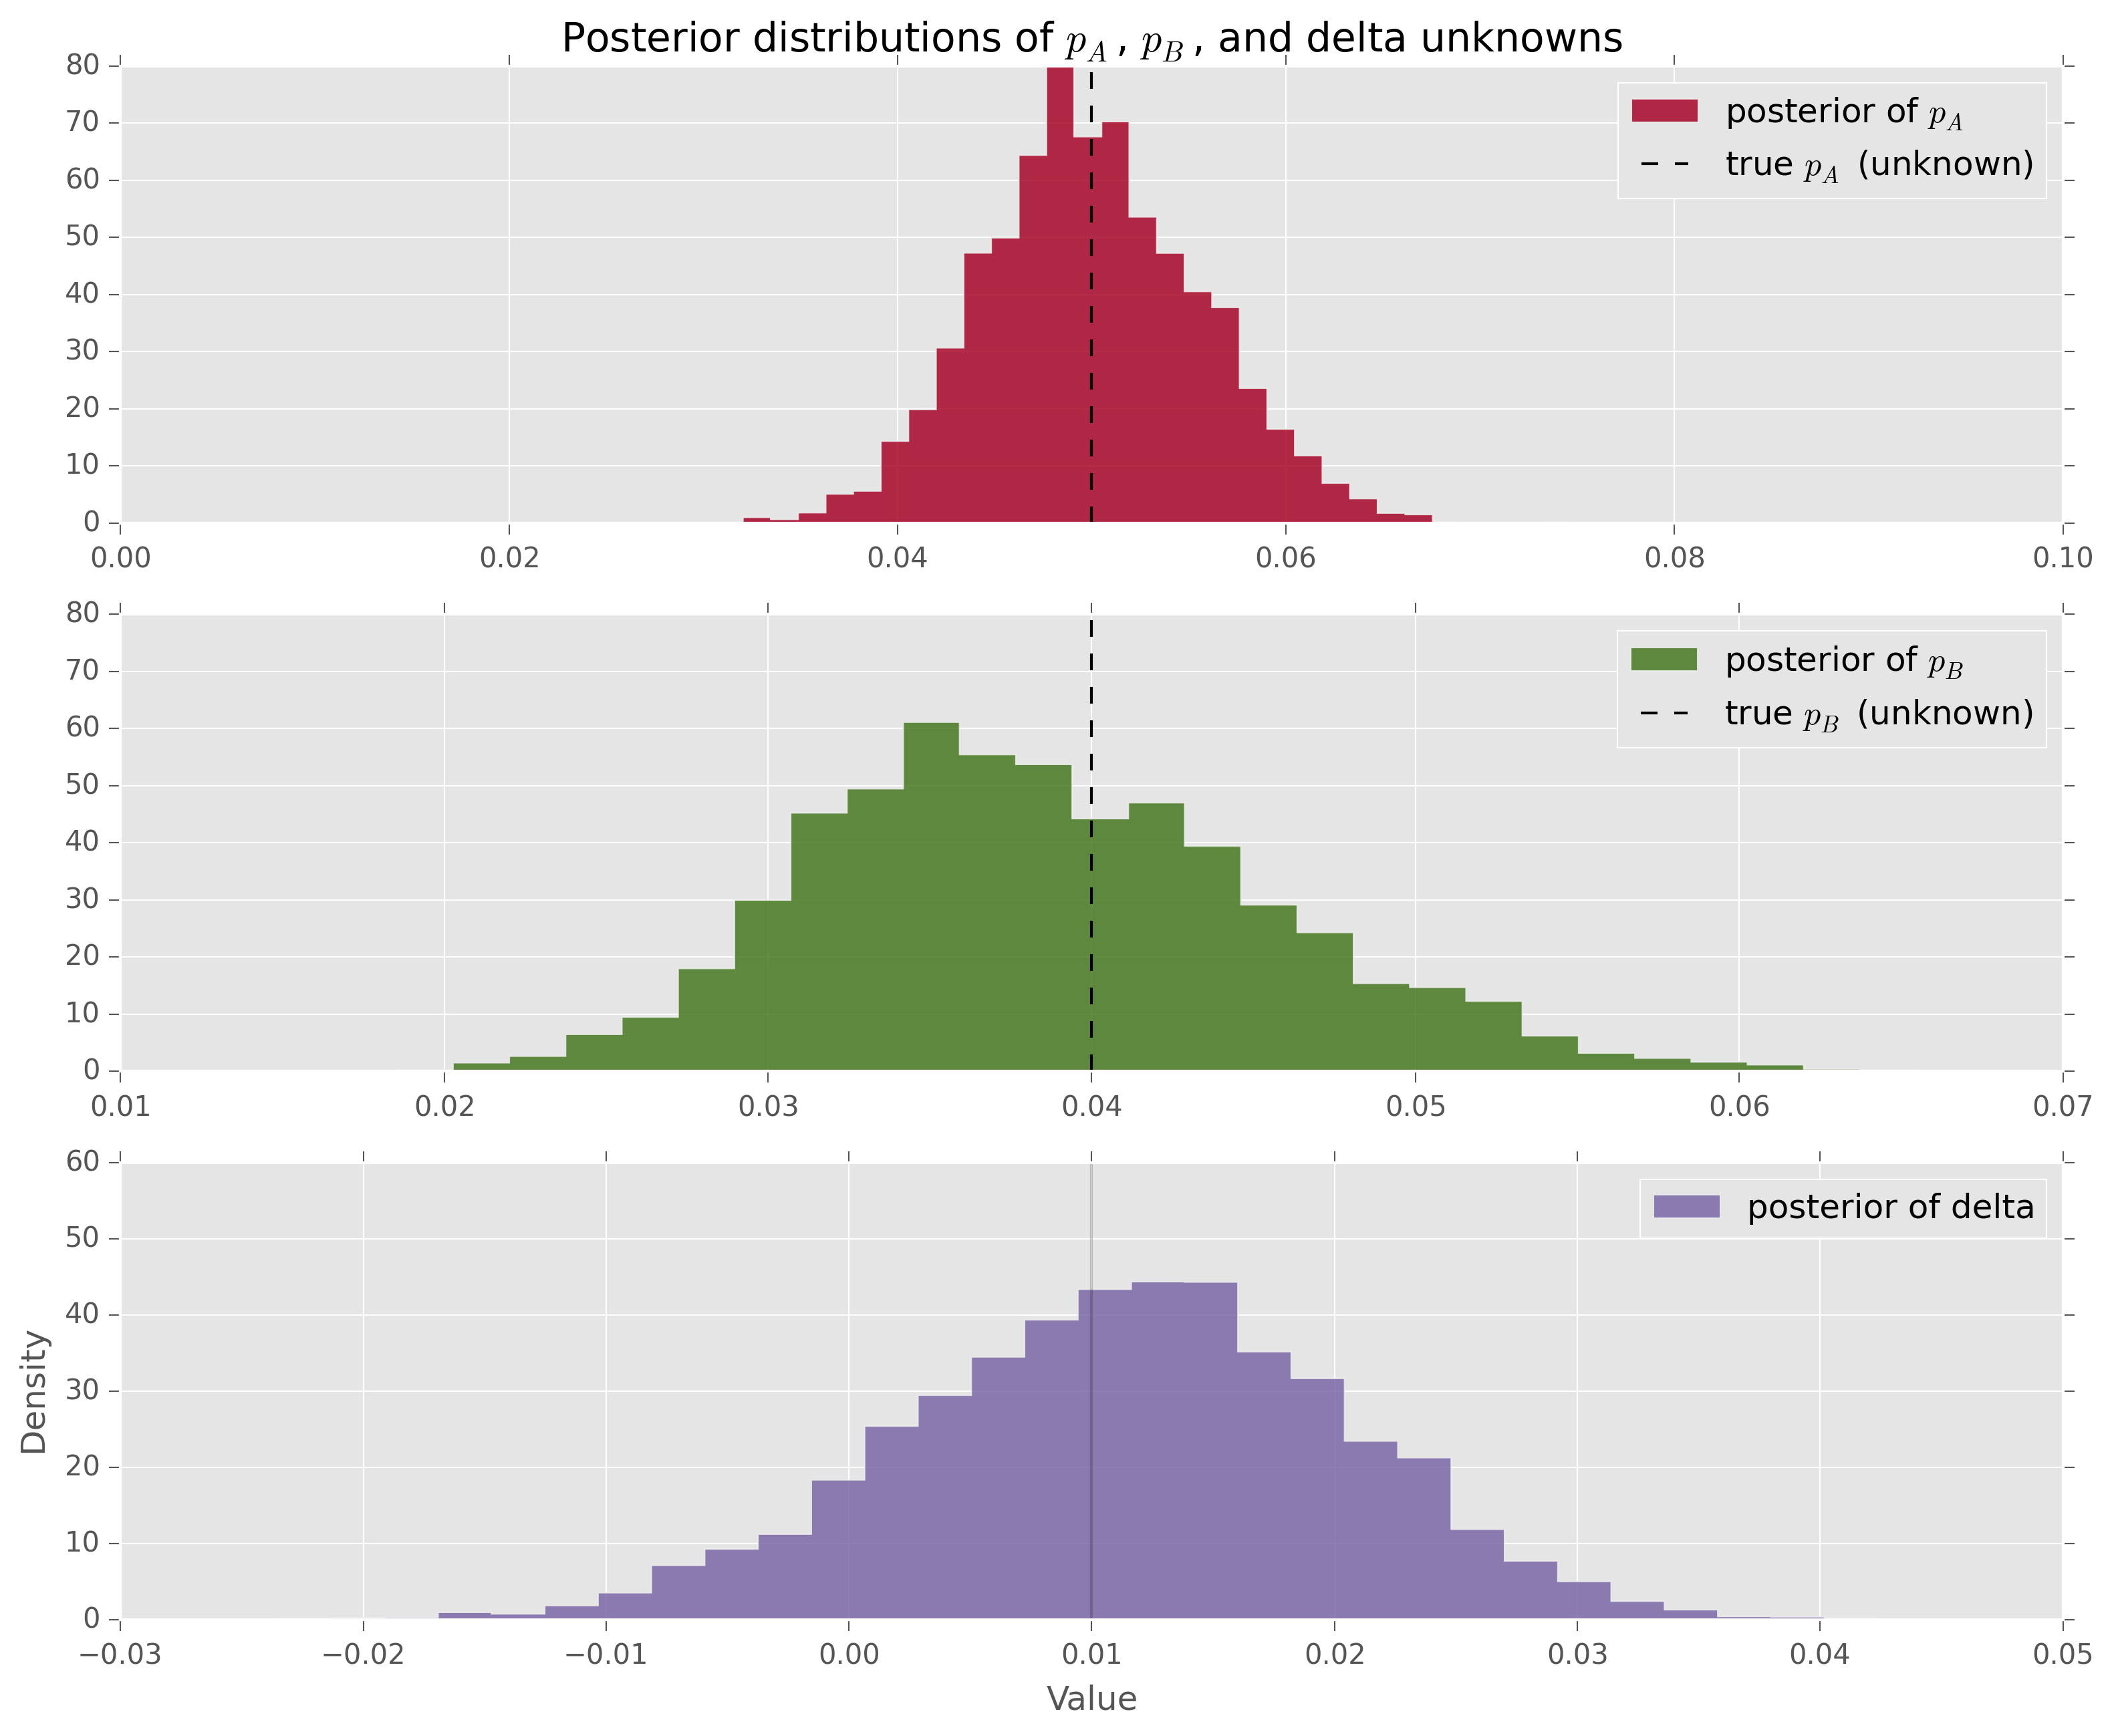

In [139]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled',bins=30, alpha=0.85, label="posterior of $p_A$",
        color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--",
          label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")
plt.ylim(0, 80)

ax = plt.subplot(312)
plt.hist(p_B_samples, histtype='stepfilled',bins=30, alpha=0.85, label="posterior of $p_B$",
        color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--",
          label="true $p_B$ (unknown)")
plt.legend(loc="upper right")
plt.ylim(0, 80)


ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled',bins=30, alpha=0.85, 
        label="posterior of delta",color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, color="black", alpha=0.2)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(loc="upper right")

Notice that as a result of $N_B < N_A$, that is, we have less data from site B - our posterior distribution of $p_B$ is fatter, implying we are less certain about the true value of $p_B$ thatn we are of $p_A$. This is easier to see if we ploot the two posteriors on the same figure:

(0, 80)

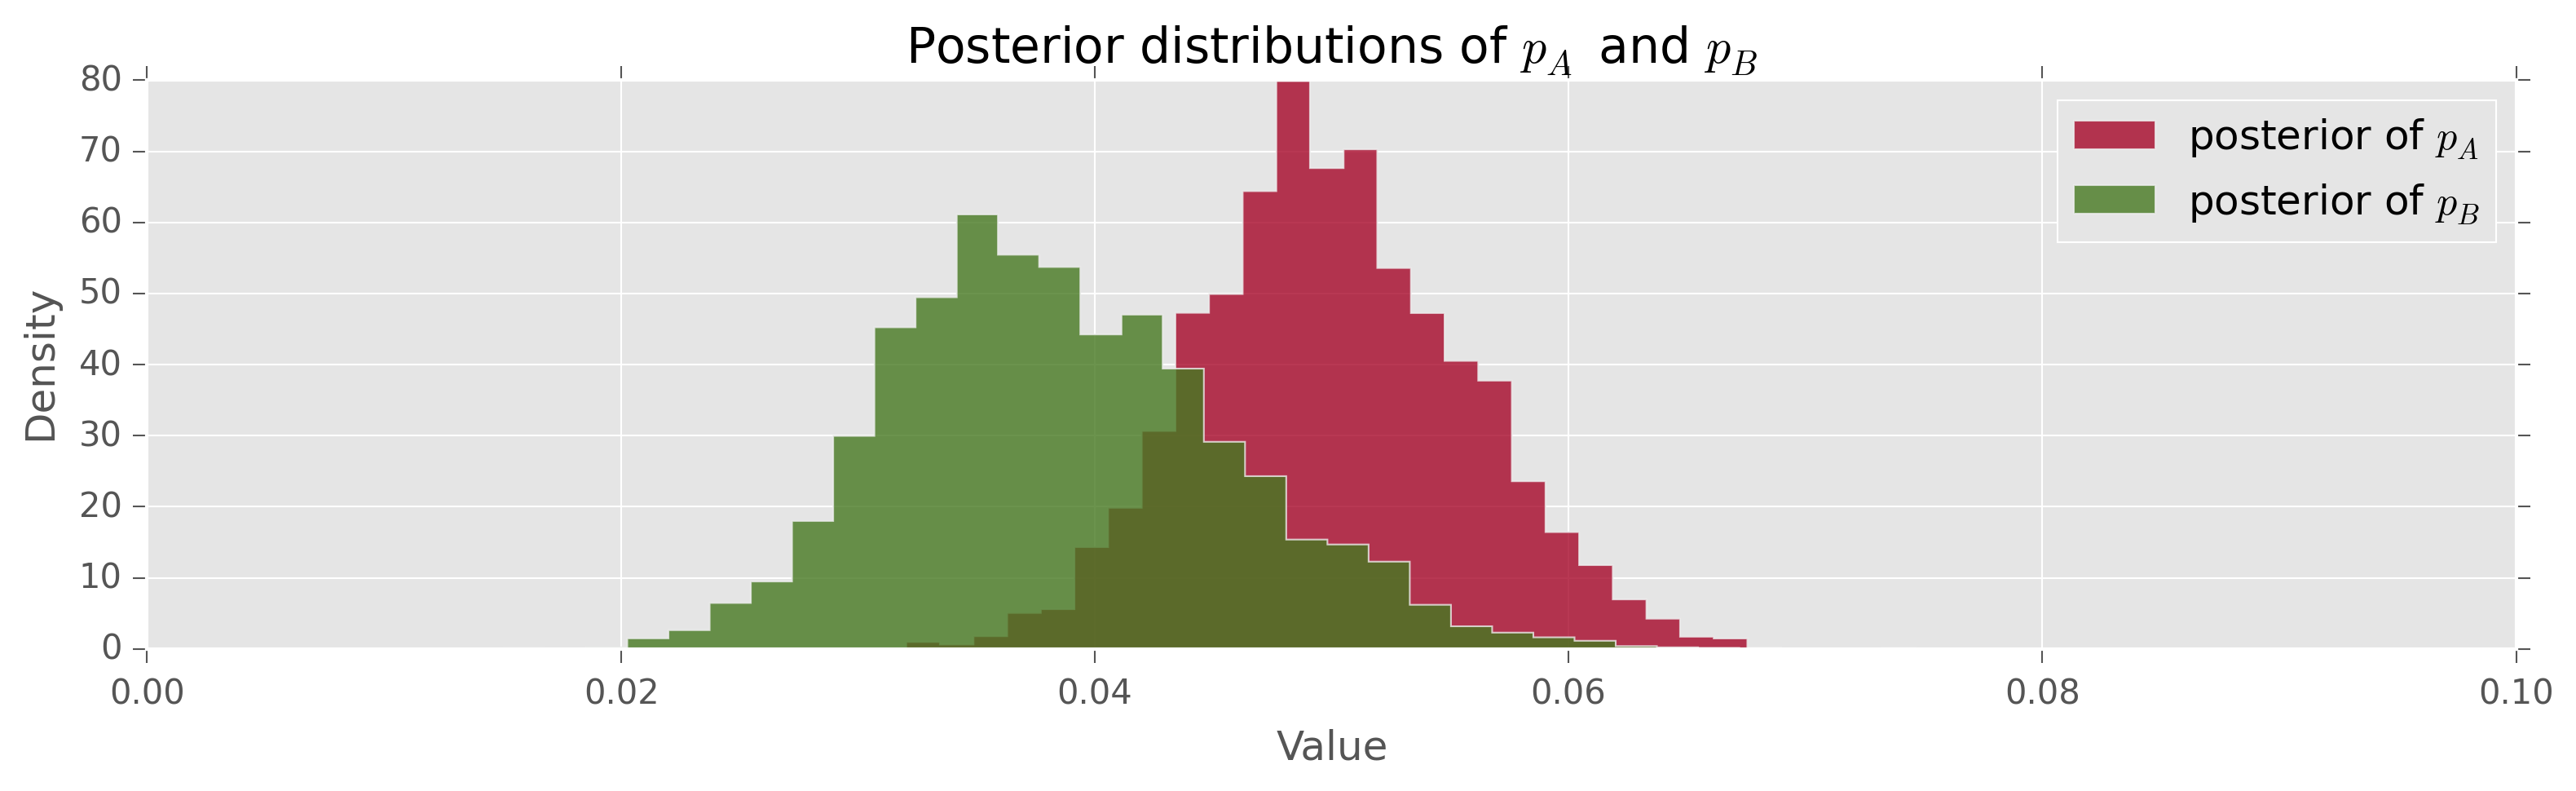

In [140]:
figsize(12.5, 3)

# histogram of posteriors

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.80,
        label="posterior of $p_A$",
        color="#A60628", normed=True)
plt.hist(p_B_samples,histtype="stepfilled",bins=30,alpha=0.80,
        label="posterior of $p_B$",
         color="#467821", normed=True)
plt.legend(loc="upper right")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior distributions of $p_A$ and $p_B$")
plt.ylim(0, 80)

In [141]:
# Count the number of samples less than 0, i.e., the area under the curve
# before 0, representing the probability that site A is worse than site B.
print "Probability site A is WORSE than site B: %.3f " % (delta_samples < 0).mean()
print "Probability site A is BETTER than site B: %.3f " % (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.107 
Probability site A is BETTER than site B: 0.892 


If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to beign with, each additional data point for site B contributes more inferential "power" than each additional data point for site A).

Try plahing with the parameters ```true_p_A, true_p_B, N_A``` and ```N_B``` to see what the posterior of delta looks like.
Notice that in all this, the difference in sample sizes between site A and site B was never mentioned; it naturally fits into Bayesian analysis.

I hope the readers feel that this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practitioners. In Chapter 5, we will see two extensions of this model: the first to help dynamically adjust for good sites, and the second to improve the speed of this computation by reducing the analysis to a single equation.